In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(["science", "high-vis"])

2018 32.48 2061.56
2019 27.18 5008.13
2020 23.25 2014.77
2021 39.57 8995.26
2022 69.11 2539.16


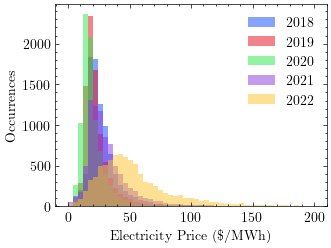

In [77]:
data = pd.read_csv("ercot_eia.csv", index_col=0)
# Rescale the PRICE variable with a RobustScaler (median and IQR) on a year-by-year basis
price = data["PRICE"].values
dates = pd.date_range(start="2018-01-01 00:00", periods=len(price), freq="h")
bins = np.linspace(price.min(), 200, 50)

for year in range(2018, 2023):
    plt.hist(price[dates.year == year], bins=bins, label=year, alpha=0.5)
    print(year, np.percentile(price[dates.year == year], 75), np.max(price[dates.year == year]))
plt.legend()
plt.xlabel("Electricity Price (\$/MWh)")
plt.ylabel("Occurrences")
plt.savefig("../../plots/yearly_price_histogram.png", dpi=300, bbox_inches="tight")
plt.show()

with open("../../plots/yearly_price_histogram.txt", "w") as f:
    f.write("Histograms of the day-ahead system average electricity price in ERCOT for the years 2018-2022.\n"
            "The right tails of the distributions are truncated to $200/MWh to improve visibility of the main body of the distributions.\n"
            "The distributions have maximum values as high as $9000/MWh.\n\n"
            "Plot generated in file \"data/ERCOT/eia_rescale.ipynb\"")

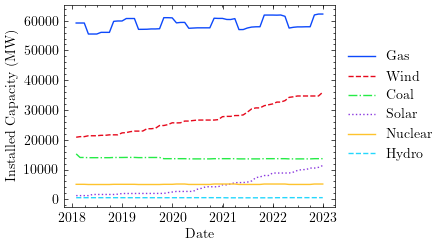

In [78]:
context_vals = pd.read_csv("monthly_context.csv")
context_vals.index = pd.date_range(start="2018-01-01", periods=len(context_vals), freq="M")
fig, ax = plt.subplots()
# Plot the context variables in order from greatest to least final value
col_order = context_vals.iloc[-1].sort_values(ascending=False).index
for col in col_order:
    if col == "NGPRICE":
        continue
    ax.plot(context_vals[col], label=col.title())
ax.set_ylabel("Installed Capacity (MW)")
ax.set_xlabel("Date")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.savefig("../../plots/installed_capacities.png", bbox_inches="tight", dpi=300)
plt.show()
with open("../../plots/installed_capacities.txt", "w") as f:
    f.write("Total generation capacity of operational generators for each technology in ERCOT from 2018 to 2022 (source: EIA).\n")
    f.write("Plot generated in file \"data/ERCOT/eia_rescale.ipynb\"")

ERCOT has implemented a maximum electricity price of $5000/MWh, effective January 1, 2022.
While there are many previous electricity price spikes which exceed this limit, we retroactively enforce this limit.
Electricity price spikes are not generated under typical generation conditions.
Limiting the magnitude of the spikes somewhat simplifies the modeling problem, since it becomes more a question of spike duration and frequency, removing magnitude from the question.
It will also limit regression errors when predicting spike values.

Year 2018: [19.65  24.485 32.48 ] 2061.56
Year 2019: [16.65 20.51 27.18] 5000.0
Year 2020: [13.6775 17.37   23.25  ] 2014.77
Year 2021: [20.31 27.58 39.57] 5000.0
Year 2022: [33.5475 47.99   69.11  ] 2539.16
count    43824.000000
mean        87.804264
std        340.343295
min        -11.449696
25%         34.421922
50%         47.990000
75%         69.978055
max       5000.000000
Name: PRICE, dtype: float64


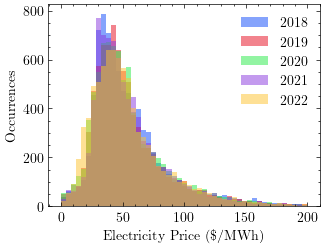

2018 -1.2389022362742261 5.629417195397208
2019 -1.2862361065941397 5.629417195397208
2020 -1.1855287431716746 5.629417195397208
2021 -1.163841662823487 5.629417195397208
2022 -1.0876541057238598 4.942414170308124


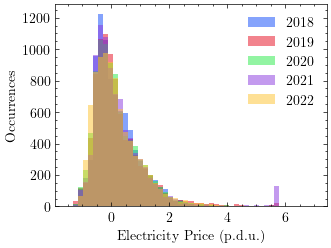

          TOTALLOAD          WIND         SOLAR         PRICE
count  43824.000000  43824.000000  43824.000000  43824.000000
mean   49073.591773      0.368188      0.270021     87.804264
std    10502.509786      0.193747      0.343301    340.343295
min    30249.910343      0.006084      0.000000    -11.449696
25%    41697.370890      0.203428      0.000000     34.421922
50%    46341.663287      0.357686      0.012418     47.990000
75%    54374.846056      0.531172      0.586041     69.978055
max    83868.176582      0.873037      1.318804   5000.000000


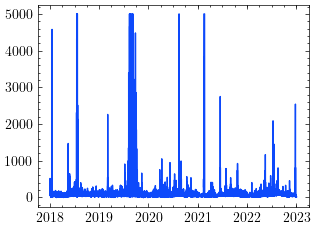

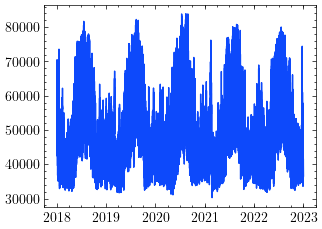

In [79]:
# Rescale the PRICE variable with a RobustScaler (median and IQR) on a year-by-year basis to look like
# the 2022 distribution. The median and IQR will be removed again when fitting the model.

med_2022 = np.median(price[dates.year == 2022])
iqr_2022 = np.percentile(price[dates.year == 2022], 75) - np.percentile(price[dates.year == 2022], 25)

fig, ax = plt.subplots()
bins = np.linspace(price.min(), 200, 50)
for year in range(2018, 2023):
    mask = (dates.year == year)
    py = price[mask]
    py_med = np.median(py)
    py_iqr = np.percentile(py, 75) - np.percentile(py, 25)
    quantiles = np.percentile(price[mask], [25, 50, 75])
    print(f"Year {year}:", quantiles, py.max())
    price[mask] = (py - py_med) / py_iqr * iqr_2022 + med_2022
    price[price > 5000] = 5000
    plt.hist(price[mask], bins=bins, label=year, alpha=0.5)
print(data["PRICE"].describe())
plt.legend()
plt.xlabel("Electricity Price (\$/MWh)")
plt.ylabel("Occurrences")
plt.savefig("../../plots/yearly_price_histogram_rescaled_2022.png", dpi=300, bbox_inches="tight")
plt.show()

with open("../../plots/yearly_price_histogram_rescaled_2022.txt", "w") as f:
    f.write("Histograms of the day-ahead system average electricity price in ERCOT for the years 2018-2022 that have been rescaled to have the same median and interquartile range as the 2022 prices.\n"
            "Plot generated in file \"data/ERCOT/eia_rescale.ipynb\"")


fig, ax = plt.subplots()
bins = np.linspace(-1.5, 7, 50)
for year in range(2018, 2023):
    mask = (dates.year == year)
    py = price[mask]
    py_med = np.median(py)
    py_iqr = np.percentile(py, 75) - np.percentile(py, 25)
    prices_scaled = np.arcsinh((py - py_med) / py_iqr)
    swoc = np.arcsinh((5000 - py_med) / py_iqr)
    prices_scaled[prices_scaled > swoc] = swoc
    print(year, min(prices_scaled), max(prices_scaled))
    plt.hist(prices_scaled, bins=bins, label=year, alpha=0.5)
# data["PRICE"] = np.arcsinh(price)
plt.legend()
plt.xlabel("Electricity Price (p.d.u.)")
plt.ylabel("Occurrences")
plt.savefig("../../plots/yearly_price_histogram_rescaled_arcsinh.png", dpi=300, bbox_inches="tight")
plt.show()

with open("../../plots/yearly_price_histogram_rescaled_arcsinh.txt", "w") as f:
    f.write("Histograms of the rescaled day-ahead system average electricity price in ERCOT for the years 2018-2022.\n"
            "Prices are rescaled on a year-by-year basis by removing the median and dividing by the interquartile range to center and scale the data.\n"
            "Then, an arcsinh function is applied to the rescaled prices to compress the tails of the distribution.\n"
            "Plot generated in file \"data/ERCOT/eia_rescale.ipynb\"")

data.loc[:, "TOTALLOAD"] *= 10502.989133706267
data.loc[:, "TOTALLOAD"] += 49073.591773469176
data.to_csv("ercot_eia_rescaled.csv")
print(data.describe())

plt.plot(dates, data["PRICE"])
plt.show()
plt.plot(dates, data["TOTALLOAD"])
plt.show()

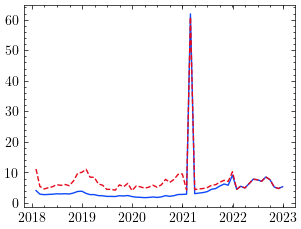

In [80]:
scaled_ngprice = context_vals["NGPRICE"].values.copy()
ngp_med_2022 = np.median(context_vals["NGPRICE"][context_vals.index.year == 2022])
ngp_iqr_2022 = np.percentile(context_vals["NGPRICE"][context_vals.index.year == 2022], 75) - np.percentile(context_vals["NGPRICE"][context_vals.index.year == 2022], 25)
for year in range(2018, 2023):
    mask = (context_vals.index.year == year)
    py = context_vals["NGPRICE"][mask]
    py_med = np.median(py)
    py_iqr = np.percentile(py, 75) - np.percentile(py, 25)
    scaled_ngprice[mask] = (py - py_med) / py_iqr * ngp_iqr_2022 + ngp_med_2022

plt.plot(context_vals["NGPRICE"])
plt.plot(context_vals.index, scaled_ngprice)
plt.show()
context_vals["NGPRICE"] = scaled_ngprice
context_vals.to_csv("monthly_context_rescaled.csv")